In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **LIBRARY IMPORT**

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from pandas.tseries.offsets import MonthEnd
import datetime
from datetime import timedelta
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install xlsxwriter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.6 MB/s eta 0:00:00


#**DATA IMPORT**

In [ ]:
# Load the "Store List" sheet from the first Excel file
data_file_path = '/content/drive/MyDrive/Capstone/ASU Dataset v4.xlsx'  # Update with your file path
store_list_df = pd.read_excel(data_file_path, sheet_name='Store List')
reg_list_df = pd.read_excel(data_file_path, sheet_name='Regulated Invoices')
dereg_list_df = pd.read_excel(data_file_path, sheet_name='De-Regulated Invoices')
energy_efficiency_df = pd.read_excel(data_file_path, sheet_name='Energy Efficiency Projects')

Step 1: Calculate Monthly Usage  - *from Service begin and end dates*

In [ ]:
# Initialize an empty list to store the results
usage_records = []
# Iterate through each row in the DataFrame to calculate monthly usage based on daily averages
for index, row in reg_list_df.iterrows():
    # Extract necessary information from the row
    physical_id = row['REID']
    start_date = pd.to_datetime(row['SERVICE BEGIN DATE'])
    end_date = pd.to_datetime(row['SERVICE END DATE'])
    total_usage = row['USAGE']
    vendor_name = row['VENDOR NAME']
    max_demand = row['Max Demand']
    # Calculate the total number of days and daily average usage
    total_days = (end_date - start_date).days + 1
    daily_average_usage = total_usage / total_days if total_days > 0 else 0
    # Distribute the usage across the months
    current_date = start_date
    while current_date <= end_date:
        end_of_month = current_date + MonthEnd(0)  # Finds the end of the current month
        days_in_month = ((min(end_of_month, end_date) - current_date).days + 1)
        monthly_usage = days_in_month * daily_average_usage
        # Calculate Service Month as the last day of the current month
        service_date = datetime.date(current_date.year, current_date.month, calendar.monthrange(current_date.year, current_date.month)[1])
        # Append the calculated monthly usage and Service Month to the list
        usage_records.append({
            'Physical ID': physical_id,
            'Vendor Name' : vendor_name,
            'Service Date': service_date,
            'Monthly Usage': monthly_usage,
            'Max Demand' : max_demand
        })
        # Move to the next month
        current_date = end_of_month + datetime.timedelta(days=1)
# Convert the list of dictionaries to a DataFrame
df_monthly_usage = pd.DataFrame(usage_records)
# At this point, every record has its own Service Month calculated before aggregation.
# Next, perform the aggregation by Physical ID, Vendor Name, Division, State, SqFt, Year, and Month to sum up 'Monthly Usage'.
df_final_usage = df_monthly_usage.groupby(['Physical ID', 'Vendor Name' ,'Service Date','Max Demand']).agg({'Monthly Usage': 'sum'}).reset_index()
df_final_usage['Monthly Usage'] = df_final_usage['Monthly Usage'].round()

In [ ]:
#To save the above file to csv :
csv_path_usage = '/content/drive/MyDrive/Capstone/Usage.csv'
df_final_usage.to_csv(csv_path_usage, index=False)

In [ ]:
#Displaying calculated column - Monthly Usage :
df_final_usage.head(10)

Physical ID               Vendor Name Service Date  Max Demand  \
0      0151AS  Calpine Energy Solutions   2017-09-30         0.0   
1      0151AS  Calpine Energy Solutions   2017-10-31         0.0   
2      0151AS  Calpine Energy Solutions   2017-11-30         0.0   
3      0151AS  Calpine Energy Solutions   2017-12-31         0.0   
4      0151AS  Calpine Energy Solutions   2018-01-31         0.0   
5      0151AS  Calpine Energy Solutions   2018-02-28         0.0   
6      0151AS  Calpine Energy Solutions   2018-03-31         0.0   
7      0151AS  Calpine Energy Solutions   2018-04-30         0.0   
8      0151AS  Calpine Energy Solutions   2018-05-31         0.0   
9      0151AS  Calpine Energy Solutions   2018-06-30         0.0   

   Monthly Usage  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  
8            0.0  
9            0.0

In [ ]:
df_final_usage.shape

(188922, 4)

In [ ]:
df_final_usage['Physical ID'].nunique()

2387

Merge data with store list

In [ ]:
# Merge the dataframes
merged_df = pd.merge(store_list_df, df_final_usage, on='Physical ID', how='inner', suffixes=('', '_drop'))
# Identify and drop the duplicated columns (those with '_drop' suffix)
merged_df = merged_df[[c for c in merged_df.columns if not c.endswith('_drop')]]
merged_df.head(10)

Physical ID Asset Type Division      City  ST    ZIP   SqFt  \
0      0151AS      Store    Jewel  Glenview  IL  60026  63523   
1      0151AS      Store    Jewel  Glenview  IL  60026  63523   
2      0151AS      Store    Jewel  Glenview  IL  60026  63523   
3      0151AS      Store    Jewel  Glenview  IL  60026  63523   
4      0151AS      Store    Jewel  Glenview  IL  60026  63523   
5      0151AS      Store    Jewel  Glenview  IL  60026  63523   
6      0151AS      Store    Jewel  Glenview  IL  60026  63523   
7      0151AS      Store    Jewel  Glenview  IL  60026  63523   
8      0151AS      Store    Jewel  Glenview  IL  60026  63523   
9      0151AS      Store    Jewel  Glenview  IL  60026  63523   

  Store Opening Date Last Remodel Date Electricity Type De-regulated Supplier  \
0         2014-01-13        2021-12-03     De-regulated                 ComEd   
1         2014-01-13        2021-12-03     De-regulated                 ComEd   
2         2014-01-13        2021-12-03     De-regulated                 ComEd   
3         2014-01-13        2021-12-03     De-regulated                 ComEd   
4         2014-01-13        2021-12-03     De-regulated                 ComEd   
5         2014-01-13        2021-12-03     De-regulated                 ComEd   
6         2014-01-13        2021-12-03     De-regulated                 ComEd   
7         2014-01-13        2021-12-03     De-regulated                 ComEd   
8         2014-01-13        2021-12-03     De-regulated                 ComEd   
9         2014-01-13        2021-12-03     De-regulated                 ComEd   

  Solar               Vendor Name Service Date  Monthly Usage  
0    No  Calpine Energy Solutions   2017-09-30            0.0  
1    No  Calpine Energy Solutions   2017-10-31            0.0  
2    No  Calpine Energy Solutions   2017-11-30            0.0  
3    No  Calpine Energy Solutions   2017-12-31            0.0  
4    No  Calpine Energy Solutions   2018-01-31            0.0  
5    No  Calpine Energy Solutions   2018-02-28            0.0  
6    No  Calpine Energy Solutions   2018-03-31            0.0  
7    No  Calpine Energy Solutions   2018-04-30            0.0  
8    No  Calpine Energy Solutions   2018-05-31            0.0  
9    No  Calpine Energy Solutions   2018-06-30            0.0

#**EXPLORATORY DATA ANALYSIS**

# TYPES OF ASSETS

In [ ]:
# Get distinct count for each asset type
unique_physical_id_by_asset_type = merged_df.groupby('Asset Type')['Physical ID'].nunique()

print("Distinct count for each Asset Type:")
print(" ")
for asset_type, count in unique_physical_id_by_asset_type.items():
    print(f"{asset_type:12} {count}")
print("")
print(f"Total count of assets :{merged_df['Physical ID'].nunique()}")

Distinct count for each Asset Type:
 
Fuel Center  318
MFC          1
Store        2066

Total count of assets :2385


# HISTOGRAM BEFORE NORMALIZATION

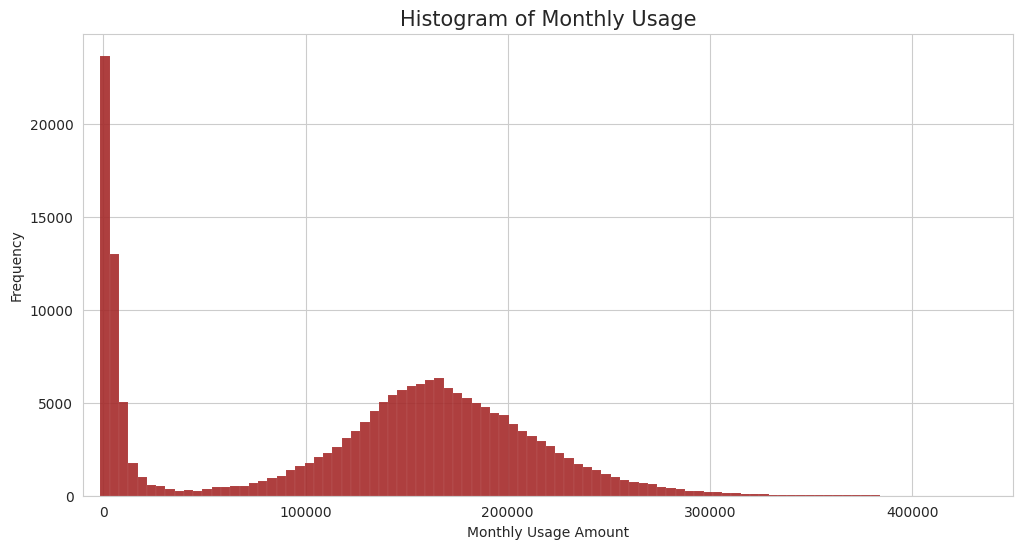

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))  # You can adjust the figure size as needed
# Create the histogram with Seaborn
sns.histplot(merged_df['Monthly Usage'], color="brown", alpha=0.9)
# Set the title of the plot
plt.title("Histogram of Monthly Usage", fontsize=15)
plt.xlim(-10000,450000)
# Add x and y axis labels
plt.xlabel('Monthly Usage Amount')
plt.ylabel('Frequency')
# Show the plot
plt.show()

#**DATA NORMALIZATION**

SEPARATING SOLAR AND NON-SOLAR VENDORS

In [ ]:
# Filter rows where the vendor name contains 'solar' (case insensitive)
df_solar= merged_df[merged_df['Vendor Name'].str.contains('solar', case=False, na=False)]
solar_vendors = df_solar["Physical ID"].nunique()
print(f"Count of solar vendors:{solar_vendors}")
# Now remove those rows from the original DataFrame to have a DataFrame without solar vendors
df_reg = merged_df[~merged_df['Vendor Name'].str.contains('solar', case=False, na=False)]
rem_rec = merged_df.shape[0] - df_reg.shape[0]
print(f"Number of records removed:{rem_rec}")

Count of solar vendors:32
Number of records removed:1495


In [ ]:
negative_values_count = (df_reg['Monthly Usage'] < 0).sum()
print(f"Count of negative values in 'Monthly Usage': {negative_values_count}")

Count of negative values in 'Monthly Usage': 1


In [ ]:
df_neg = df_reg[df_reg['Monthly Usage']< 0]
df_neg

Physical ID Asset Type Division       City  ST    ZIP   SqFt  \
72553      1698AS      Store   Denver  Lone Tree  CO  80124  55650   

      Store Opening Date Last Remodel Date Electricity Type  \
72553         1998-09-11        2018-08-24        Regulated   

      De-regulated Supplier Solar          Vendor Name Service Date  \
72553                   NaN   Yes  GS Direct LLC (AU1)   2022-08-31   

       Monthly Usage  
72553         -830.0

REMOVE NEGATIVE VALUES

In [ ]:
# Remove rows with negative 'Monthly Usage' values
df_final_usage = df_reg[df_reg['Monthly Usage'] >= 0]
# Reset index if needed, after removing rows
df_final_usage.reset_index(drop=True, inplace=True)
# Check the operation was successful
print(df_final_usage['Monthly Usage'].describe())

count    1.872020e+05
mean     1.299413e+05
std      8.456411e+04
min      0.000000e+00
25%      6.526800e+04
50%      1.495555e+05
75%      1.868970e+05
max      6.625996e+06
Name: Monthly Usage, dtype: float64


In [ ]:
df_final_usage = df_reg

CHECK RANGE OF SERVICE DATES

In [ ]:
# Filter the dataset for the desired date range
df_final_usage['Service Date'] = pd.to_datetime(df_final_usage['Service Date'])
df = df_final_usage[(df_final_usage['Service Date'].dt.year >= 2016) & (df_final_usage['Service Date'].dt.year <= 2025)]
fig = px.scatter(df, x='Service Date', y='Physical ID', title='Range of Service Dates for Each Physical ID')
# Update the x-axis to display the years from 2016 to 2025
fig.update_xaxes(range=['2016-01-01', '2025-12-31'])
# Show the plot
fig.show()

FILTER THE DATA TO BE IN SAME PERIOD

In [ ]:
df = df_final_usage
# Filter the dataset based on the date criteria
df['Service Date'] = pd.to_datetime(df['Service Date'])
df_filtered = df[(df['Service Date'] >= "2017-09-01") & (df['Service Date'] <= "2023-12-30")]

In [ ]:
#To save the above file to csv :
df_filtered.to_csv('/content/drive/MyDrive/Capstone/filtered.csv', index=False)

Remove date mismatch between store opening and service date

In [ ]:
kept_rows = []  # Rows that meet the condition will be stored here temporarily
removed_rows = []  # Rows that do not meet the condition will be stored here temporarily
for physical_id in df_filtered['Physical ID'].unique():
    subset = df_filtered[df_filtered['Physical ID'] == physical_id]
    first_service_date = subset['Service Date'].min()
    threshold_date = first_service_date + pd.DateOffset(months=4)

    # Splitting the subset based on the condition
    keep = subset[subset['Store Opening Date'] <= threshold_date]
    remove = subset[subset['Store Opening Date'] > threshold_date]

    # Append these to the respective lists
    kept_rows.append(keep)
    removed_rows.append(remove)
final_kept_df = pd.concat(kept_rows, ignore_index=True)
final_removed_df = pd.concat(removed_rows, ignore_index=True)


In [ ]:
print(f"Number of records removed:{final_removed_df.shape[0]}")

Number of records removed:1145


REMOVE TEXAS DATA

In [ ]:
df = final_kept_df
# Separate the entries where ST is TX
df_tx = final_kept_df[final_kept_df['ST'] == 'TX']
df_filtered_no_tx = final_kept_df[final_kept_df['ST'] != 'TX']
new_df = df_filtered_no_tx
dat_rem = final_kept_df.shape[0] - new_df.shape[0]
print(f"Number of records removed:{dat_rem}")

Number of records removed:2687


REMOVE STORE INFO THAT HAVE LESS THAN 4 MONTHS DATA IN A YEAR

In [ ]:
# Ensure 'Service Date' is of datetime type
df = new_df
df['Service Date'] = pd.to_datetime(df['Service Date'])
# Extract year from 'Service Date'
df['Year'] = df['Service Date'].dt.year
# Group by 'Physical ID' and 'Year', then filter out those groups with less than 6 entries
grouped = df.groupby(['Physical ID', 'Year'])
df = grouped.filter(lambda x: len(x) >= 4)
# df_filtered now contains only those groups with 4 or more 'Service Date' entries per 'Physical ID' per year

Removing rows that have all 0's for same vendor and store

In [ ]:
# Count the number of zeros in the 'Monthly Usage' column
number_of_zeros = (df['Monthly Usage'] == 0).sum()
print(f"Number of zeros in 'Monthly Usage': {number_of_zeros}")
# Calculate the total number of rows in the dataframe
total_rows = df.shape[0]
# Calculate the percentage of zeros in the 'Monthly Usage' column
percentage_of_zeros = (number_of_zeros / total_rows) * 100
print(f"Percentage of data that is 0 in 'Monthly Usage': {percentage_of_zeros:.2f}%")

Number of zeros in 'Monthly Usage': 21088
Percentage of data that is 0 in 'Monthly Usage': 12.37%


In [ ]:
# Group by 'Physical ID' and 'Vendor Name' and filter out groups where all 'Monthly Usage' values are zero
grouped = df.groupby(['Physical ID', 'Vendor Name'])
filtered_df = grouped.filter(lambda x: not (x['Monthly Usage'] == 0).all())
# Determine the number of records removed
original_count = len(df)
filtered_count = len(filtered_df)
records_removed = original_count - filtered_count
print(f"Number of records after filtering: {filtered_count}")
print(f"Number of records removed: {records_removed}")

Number of records after filtering: 149446
Number of records removed: 20965


In [ ]:
#filtered_df

HISTOGRAM FOR REGULATED INVOICE WITHOUT SOLAR DATA

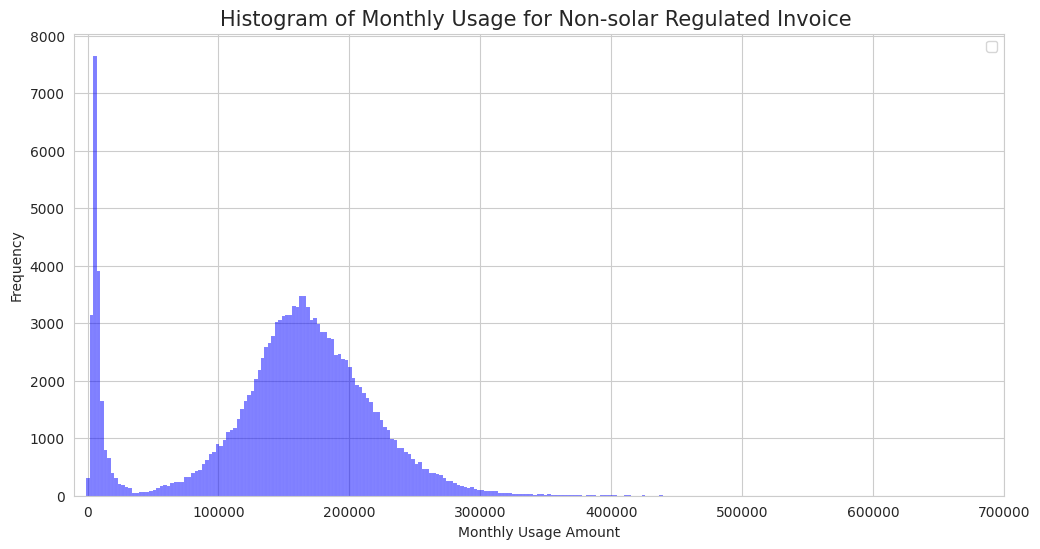

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))  # You can adjust the figure size as needed
# Create the histogram with Seaborn
sns.histplot(filtered_df['Monthly Usage'], color = "blue",alpha=0.5,bins='auto')
# Set the title of the plot
plt.title("Histogram of Monthly Usage for Non-solar Regulated Invoice ", fontsize=15)
# Set the x-axis limits to zoom into the dense part of the histogram
plt.xlim(-10000, 700000)
# Add x and y axis labels
plt.xlabel('Monthly Usage Amount')
plt.ylabel('Frequency')
# Show legend
plt.legend()
# Show the plot
plt.show()

SEPERATING ASSET TYPES

In [ ]:
# Filter the DataFrame for each asset type
store_df = filtered_df[filtered_df['Asset Type'] == 'Store']
fuel_center_df = filtered_df[filtered_df['Asset Type'] == 'Fuel Center']
mfc_df = filtered_df[filtered_df['Asset Type'] == 'MFC']

In [ ]:
print(store_df.shape[0])
print(fuel_center_df.shape[0])
print(mfc_df.shape[0])

131527
17919
0


STORE USAGE HISTOGRAM

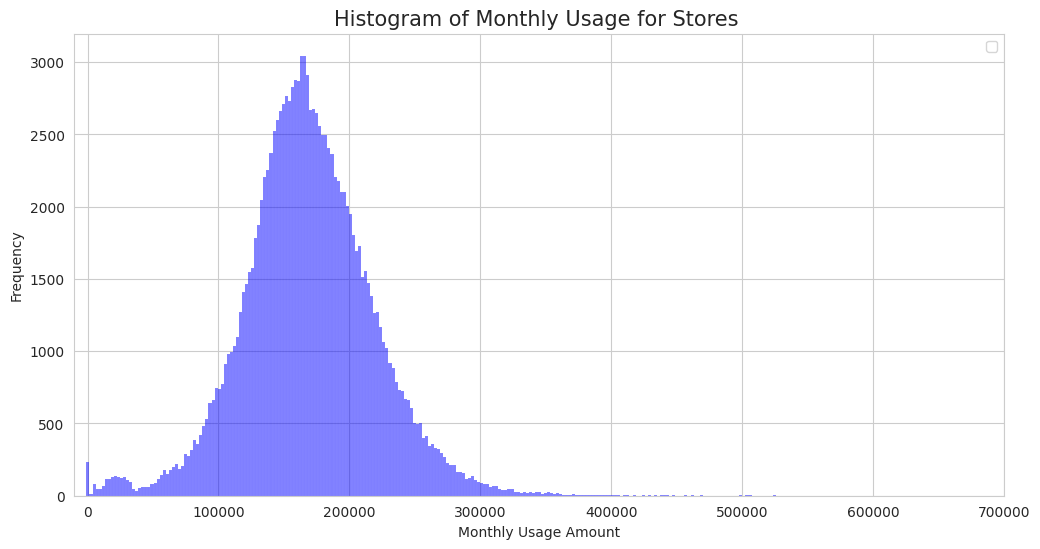

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))  # You can adjust the figure size as needed
# Create the histogram with Seaborn
sns.histplot(store_df['Monthly Usage'], color = "blue",alpha=0.5,bins='auto')
# Set the title of the plot
plt.title("Histogram of Monthly Usage for Stores ", fontsize=15)
# Set the x-axis limits to zoom into the dense part of the histogram
# You can adjust the range according to your data
#plt.xlim(df_final_usage['Monthly Usage'].min(), df_final_usage['Monthly Usage'].quantile(0.99))
plt.xlim(-10000, 700000)
# Add x and y axis labels
plt.xlabel('Monthly Usage Amount')
plt.ylabel('Frequency')
# Show legend
plt.legend()
# Show the plot
plt.show()

FINDING OUTLIERS IN STORE DATA

In [ ]:
def find_outliers_iqr(dataframe, column_name):
    # Calculate Q1, Q3 and IQR
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Find outliers
    outliers = dataframe[(dataframe[column_name] < lower_bound) | (dataframe[column_name] > upper_bound)]
    return outliers, lower_bound, upper_bound
# Usage of the function with your DataFrame
outliers_store, lower_bound, upper_bound = find_outliers_iqr(store_df, 'Monthly Usage')
print(f"Outliers in Store Data:\n{outliers_store}")
print(f"Lower Bound for Outliers: {lower_bound}")
print(f"Upper Bound for Outliers: {upper_bound}")

Outliers in Store Data:
       Physical ID Asset Type      Division        City  ST    ZIP   SqFt  \
22          0151AS      Store         Jewel    Glenview  IL  60026  63523   
23          0151AS      Store         Jewel    Glenview  IL  60026  63523   
162         0154AS      Store     Southwest     Phoenix  AZ  85086  57560   
420         0158AS      Store        Denver  Centennial  CO  80112  49770   
421         0158AS      Store        Denver  Centennial  CO  80112  49770   
...            ...        ...           ...         ...  ..    ...    ...   
176918      5063AS      Store  Mid-Atlantic     Newtown  PA  18940  66621   
176919      5063AS      Store  Mid-Atlantic     Newtown  PA  18940  66621   
176930      5063AS      Store  Mid-Atlantic     Newtown  PA  18940  66621   
176942      5063AS      Store  Mid-Atlantic     Newtown  PA  18940  66621   
176943      5063AS      Store  Mid-Atlantic     Newtown  PA  18940  66621   

       Store Opening Date Last Remodel Date Electri

In [ ]:
# Marking rows as outliers based on the 'Monthly Usage' column using the identified bounds
store_df['Is_outlier'] = ((store_df['Monthly Usage'] < lower_bound) |
                                (store_df['Monthly Usage'] > upper_bound))

# Displaying a portion of the DataFrame to verify the 'is_outlier' column
store_df[['Physical ID', 'Service Date', 'Monthly Usage', 'Is_outlier']].head()

Physical ID Service Date  Monthly Usage  Is_outlier
12      0151AS   2017-09-30       160879.0       False
13      0151AS   2017-10-31       276902.0       False
14      0151AS   2017-11-30       255853.0       False
15      0151AS   2017-12-31       261024.0       False
16      0151AS   2018-01-31       261788.0       False

SAVE THE OUTLIERS DATAFRAME

In [ ]:
#To save the above file to csv :
outliers_store.to_csv('/content/drive/MyDrive/Capstone/Outlier_store.csv', index=False)
store_df.to_csv('/content/drive/MyDrive/Capstone/Store_Usage.csv', index=False)

In [ ]:
outliers_store.shape[0]

3768

IMPUTING THE OUTLIER VALUES

In [ ]:
from datetime import datetime
store_usage_df = store_df.copy()
# Ensure 'Service Date' is in datetime format for manipulation
store_usage_df['Service Date'] = pd.to_datetime(store_usage_df['Service Date'])

# Function to calculate the average monthly usage excluding the outlier year
def calculate_replace_outliers(row):
    if row['Is_outlier']:
        physical_id = row['Physical ID']
        outlier_month = row['Service Date'].month
        outlier_year = row['Service Date'].year

        # Filter dataset for the same Physical ID and month, excluding the outlier year
        similar_records = store_usage_df[(store_usage_df['Physical ID'] == physical_id) &
                                         (store_usage_df['Service Date'].dt.month == outlier_month) &
                                         (store_usage_df['Service Date'].dt.year != outlier_year)]

        # Calculate the average Monthly Usage if similar records exist, else use the current value
        if not similar_records.empty:
            avg_monthly_usage = similar_records['Monthly Usage'].mean()
            return avg_monthly_usage
    return row['Monthly Usage']

# Applying the function to replace outlier monthly usages
store_usage_df['Monthly Usage'] = store_usage_df.apply(calculate_replace_outliers, axis=1)

# Verify changes by showing rows marked as outliers to see if their Monthly Usage has been updated
store_usage_df[store_usage_df['Is_outlier']].head()


Physical ID Asset Type   Division        City  ST    ZIP   SqFt  \
22       0151AS      Store      Jewel    Glenview  IL  60026  63523   
23       0151AS      Store      Jewel    Glenview  IL  60026  63523   
162      0154AS      Store  Southwest     Phoenix  AZ  85086  57560   
420      0158AS      Store     Denver  Centennial  CO  80112  49770   
421      0158AS      Store     Denver  Centennial  CO  80112  49770   

    Store Opening Date Last Remodel Date Electricity Type  \
22          2014-01-13        2021-12-03     De-regulated   
23          2014-01-13        2021-12-03     De-regulated   
162         2003-02-05        2021-06-11        Regulated   
420         1973-09-30        2007-09-29        Regulated   
421         1973-09-30        2007-09-29        Regulated   

    De-regulated Supplier Solar  Vendor Name Service Date  Monthly Usage  \
22                  ComEd    No        ComEd   2018-07-31      258110.40   
23                  ComEd    No        ComEd   2018-08-31      257219.20   
162                   NaN    No          APS   2017-09-30      189823.50   
420                   NaN    No  Xcel Energy   2019-09-30      139374.50   
421                   NaN    No  Xcel Energy   2019-10-31      122943.75   

     Year  Is_outlier  
22   2018        True  
23   2018        True  
162  2017        True  
420  2019        True  
421  2019        True

In [ ]:
store_usage_df.head()

Physical ID Asset Type Division      City  ST    ZIP   SqFt  \
12      0151AS      Store    Jewel  Glenview  IL  60026  63523   
13      0151AS      Store    Jewel  Glenview  IL  60026  63523   
14      0151AS      Store    Jewel  Glenview  IL  60026  63523   
15      0151AS      Store    Jewel  Glenview  IL  60026  63523   
16      0151AS      Store    Jewel  Glenview  IL  60026  63523   

   Store Opening Date Last Remodel Date Electricity Type  \
12         2014-01-13        2021-12-03     De-regulated   
13         2014-01-13        2021-12-03     De-regulated   
14         2014-01-13        2021-12-03     De-regulated   
15         2014-01-13        2021-12-03     De-regulated   
16         2014-01-13        2021-12-03     De-regulated   

   De-regulated Supplier Solar Vendor Name Service Date  Monthly Usage  Year  \
12                 ComEd    No       ComEd   2017-09-30       160879.0  2017   
13                 ComEd    No       ComEd   2017-10-31       276902.0  2017   
14                 ComEd    No       ComEd   2017-11-30       255853.0  2017   
15                 ComEd    No       ComEd   2017-12-31       261024.0  2017   
16                 ComEd    No       ComEd   2018-01-31       261788.0  2018   

    Is_outlier  
12       False  
13       False  
14       False  
15       False  
16       False

In [ ]:
store_usage_df.shape[0]

131527

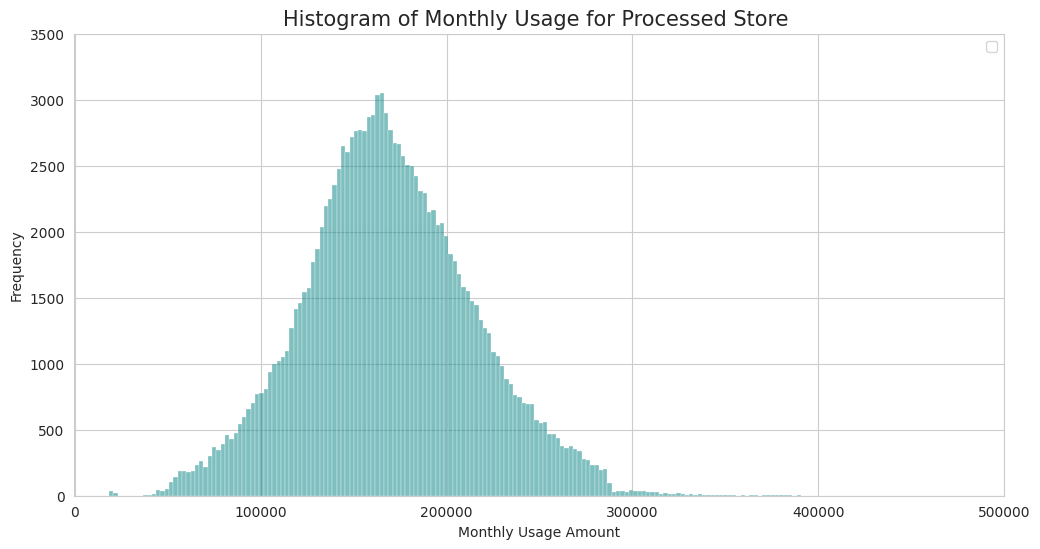

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))  # You can adjust the figure size as needed

# Create the histogram with Seaborn
sns.histplot(store_usage_df['Monthly Usage'], color = "teal",alpha=0.5,bins='auto')

# Set the title of the plot
plt.title("Histogram of Monthly Usage for Processed Store ", fontsize=15)

# Set the x-axis limits to zoom into the dense part of the histogram
# You can adjust the range according to your data
#plt.xlim(df_final_usage['Monthly Usage'].min(), df_final_usage['Monthly Usage'].quantile(0.99))
plt.xlim(-100, 500000)
plt.ylim(0,3500)
# Add x and y axis labels
plt.xlabel('Monthly Usage Amount')
plt.ylabel('Frequency')
# Show legend
plt.legend()
# Show the plot
plt.show()

In [ ]:
get_data = store_usage_df[store_usage_df["Monthly Usage"]<50000]
get_data

Physical ID Asset Type  Division        City  ST    ZIP   SqFt  \
27582       0764AS      Store  InterMtn      Shelby  MT  59474  14577   
38618       0982AS      Store  InterMtn      Harlem  MT  59526  10000   
38630       0982AS      Store  InterMtn      Harlem  MT  59526  10000   
38640       0982AS      Store  InterMtn      Harlem  MT  59526  10000   
38642       0982AS      Store  InterMtn      Harlem  MT  59526  10000   
...            ...        ...       ...         ...  ..    ...    ...   
103004      2408AS      Store    NorCal  Tahoe City  CA  96145  28631   
103005      2408AS      Store    NorCal  Tahoe City  CA  96145  28631   
103006      2408AS      Store    NorCal  Tahoe City  CA  96145  28631   
117608      2757AS      Store    NorCal  Santa Cruz  CA  95060  60275   
168619      4162AS      Store  InterMtn     Glasgow  MT  59230  15632   

       Store Opening Date Last Remodel Date Electricity Type  \
27582          1962-01-01        2008-12-03        Regulated   
38618          1941-01-01        2021-02-15        Regulated   
38630          1941-01-01        2021-02-15        Regulated   
38640          1941-01-01        2021-02-15        Regulated   
38642          1941-01-01        2021-02-15        Regulated   
...                   ...               ...              ...   
103004         1975-11-16        2018-08-18        Regulated   
103005         1975-11-16        2018-08-18        Regulated   
103006         1975-11-16        2018-08-18        Regulated   
117608         2009-07-30        2009-07-30        Regulated   
168619         1998-10-01        2008-10-01        Regulated   

       De-regulated Supplier Solar                              Vendor Name  \
27582                    NaN    No  Marias River Electric Cooperative, Inc,   
38618                    NaN    No                  NorthWestern Energy, MT   
38630                    NaN    No                  NorthWestern Energy, MT   
38640                    NaN    No                  NorthWestern Energy, MT   
38642                    NaN    No                  NorthWestern Energy, MT   
...                      ...   ...                                      ...   
103004                   NaN    No                       Liberty Utility CA   
103005                   NaN    No                       Liberty Utility CA   
103006                   NaN    No                       Liberty Utility CA   
117608                   NaN   Yes            Clearway Energy Operating LLC   
168619                   NaN    No                  NorthWestern Energy, MT   

       Service Date  Monthly Usage  Year  Is_outlier  
27582    2019-02-28       48822.50  2019        True  
38618    2018-02-28       43954.20  2018        True  
38630    2019-02-28       37697.60  2019        True  
38640    2019-12-31       49169.50  2019        True  
38642    2020-02-29       37560.00  2020        True  
...             ...            ...   ...         ...  
103004   2023-09-30       49028.25  2023        True  
103005   2023-10-31       46768.30  2023        True  
103006   2023-11-30       45349.50  2023        True  
117608   2022-02-28       49697.00  2022        True  
168619   2021-02-28       49784.25  2021        True  

[176 rows x 17 columns]

In [ ]:
#To save the above file to csv :
store_usage_df.to_csv('/content/drive/MyDrive/Capstone/Fixed_store.csv', index=False)

FUEL CENTER USAGE HISTOGRAM

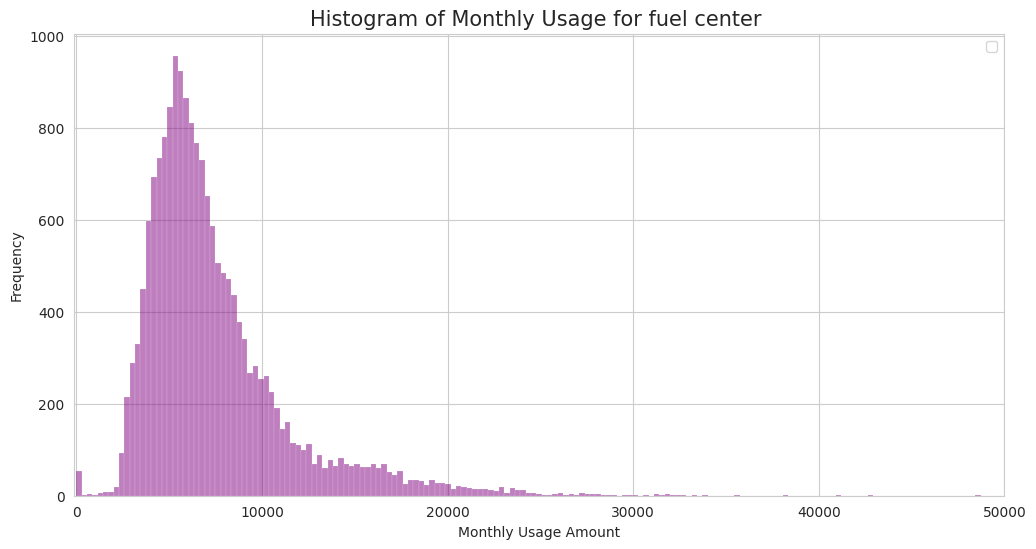

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))  # You can adjust the figure size as needed

# Create the histogram with Seaborn
sns.histplot(fuel_center_df['Monthly Usage'], color = "purple",alpha=0.5,bins='auto')

# Set the title of the plot
plt.title("Histogram of Monthly Usage for fuel center ", fontsize=15)

# Set the x-axis limits to zoom into the dense part of the histogram
# You can adjust the range according to your data
#plt.xlim(df_final_usage['Monthly Usage'].min(), df_final_usage['Monthly Usage'].quantile(0.99))
plt.xlim(-100, 50000)

# Add x and y axis labels
plt.xlabel('Monthly Usage Amount')
plt.ylabel('Frequency')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Remove rows where Monthly Usage is 0
fuel_center_df = fuel_center_df[fuel_center_df['Monthly Usage'] != 0]

FINDING OUTLIERS IN FUEL CENTER DATA

In [ ]:
def find_out_iqr(dataframe, column_name):
    # Calculate Q1, Q3 and IQR
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Find outliers
    outliers = dataframe[(dataframe[column_name] < lower_bound) | (dataframe[column_name] > upper_bound)]
    return outliers, lower_bound, upper_bound
# Usage of the function with your DataFrame
outliers_fc, lower_bound, upper_bound = find_out_iqr(fuel_center_df, 'Monthly Usage')
print(f"Outliers in Store Data:\n{outliers_fc}")
print(f"Lower Bound for Outliers: {lower_bound}")
print(f"Upper Bound for Outliers: {upper_bound}")


Outliers in Store Data:
       Physical ID   Asset Type  Division            City  ST    ZIP  SqFt  \
2387        0205FC  Fuel Center    NorCal  Mountain House  CA  95391  3000   
2388        0205FC  Fuel Center    NorCal  Mountain House  CA  95391  3000   
2389        0205FC  Fuel Center    NorCal  Mountain House  CA  95391  3000   
2390        0205FC  Fuel Center    NorCal  Mountain House  CA  95391  3000   
7864        0319FC  Fuel Center  InterMtn           Boise  ID  83706  3400   
...            ...          ...       ...             ...  ..    ...   ...   
175722      4778FC  Fuel Center    NorCal            Reno  NV  89523  2732   
175723      4778FC  Fuel Center    NorCal            Reno  NV  89523  2732   
175724      4778FC  Fuel Center    NorCal            Reno  NV  89523  2732   
175725      4778FC  Fuel Center    NorCal            Reno  NV  89523  2732   
175726      4778FC  Fuel Center    NorCal            Reno  NV  89523  2732   

       Store Opening Date Last Remodel 

In [ ]:
# Marking rows as outliers based on the 'Monthly Usage' column using the identified bounds
fuel_center_df['Is_outlier'] = ((fuel_center_df['Monthly Usage'] < lower_bound) |
                                (fuel_center_df['Monthly Usage'] > upper_bound))

# Displaying a portion of the DataFrame to verify the 'is_outlier' column
fuel_center_df[['Physical ID', 'Service Date', 'Monthly Usage', 'Is_outlier']].head()

Physical ID Service Date  Monthly Usage  Is_outlier
598      0160FC   2019-01-31        10518.0       False
599      0160FC   2019-02-28         8149.0       False
600      0160FC   2019-03-31         8401.0       False
601      0160FC   2019-04-30         8888.0       False
602      0160FC   2019-05-31         9133.0       False

IMPUTING FUEL CENTER OUTLIERS

In [ ]:
from datetime import datetime
fc_usage_df = fuel_center_df
# Ensure 'Service Date' is in datetime format for manipulation
fc_usage_df['Service Date'] = pd.to_datetime(fc_usage_df['Service Date'])

# Function to calculate the average monthly usage excluding the outlier year
def calculate_replace_outliers(row):
    if row['Is_outlier']:
        physical_id = row['Physical ID']
        outlier_month = row['Service Date'].month
        outlier_year = row['Service Date'].year

        # Filter dataset for the same Physical ID and month, excluding the outlier year
        same_records = fc_usage_df[(fc_usage_df['Physical ID'] == physical_id) &
                                         (fc_usage_df['Service Date'].dt.month == outlier_month) &
                                         (fc_usage_df['Service Date'].dt.year != outlier_year)]

        # Calculate the average Monthly Usage if similar records exist, else use the current value
        if not same_records.empty:
            avg_month_usage = same_records['Monthly Usage'].mean()
            return avg_month_usage
    return row['Monthly Usage']

# Applying the function to replace outlier monthly usages
fc_usage_df['Monthly Usage'] = fc_usage_df.apply(calculate_replace_outliers, axis=1)

# Verify changes by showing rows marked as outliers to see if their Monthly Usage has been updated
fc_usage_df[fc_usage_df['Is_outlier']].head()


Physical ID   Asset Type  Division            City  ST    ZIP  SqFt  \
2387      0205FC  Fuel Center    NorCal  Mountain House  CA  95391  3000   
2388      0205FC  Fuel Center    NorCal  Mountain House  CA  95391  3000   
2389      0205FC  Fuel Center    NorCal  Mountain House  CA  95391  3000   
2390      0205FC  Fuel Center    NorCal  Mountain House  CA  95391  3000   
7864      0319FC  Fuel Center  InterMtn           Boise  ID  83706  3400   

     Store Opening Date Last Remodel Date Electricity Type  \
2387         2022-09-28               NaT        Regulated   
2388         2022-09-28               NaT        Regulated   
2389         2022-09-28               NaT        Regulated   
2390         2022-09-28               NaT        Regulated   
7864         2017-12-20               NaT        Regulated   

     De-regulated Supplier Solar                  Vendor Name Service Date  \
2387                   NaN    No  Modesto Irrigation District   2023-07-31   
2388                   NaN    No  Modesto Irrigation District   2023-08-31   
2389                   NaN    No  Modesto Irrigation District   2023-09-30   
2390                   NaN    No  Modesto Irrigation District   2023-10-31   
7864                   NaN    No                  Idaho Power   2019-01-31   

      Monthly Usage  Year  Is_outlier  
2387       16369.00  2023        True  
2388       16737.00  2023        True  
2389       15396.00  2023        True  
2390       15559.00  2023        True  
7864       15844.75  2019        True

In [ ]:
fc_usage_df.to_csv('/content/drive/MyDrive/Capstone/FC_usage.csv', index=False)

In [ ]:
combined_df = pd.concat([store_usage_df, fc_usage_df], ignore_index=True)

In [ ]:
combined_df.to_csv('/content/drive/MyDrive/Capstone/final_usage.csv', index=False)

In [ ]:
store_usage_df.columns

Index(['Physical ID', 'Asset Type', 'Division', 'City', 'ST', 'ZIP', 'SqFt',
       'Store Opening Date', 'Last Remodel Date', 'Electricity Type',
       'De-regulated Supplier', 'Solar', 'Vendor Name', 'Service Date',
       'Monthly Usage', 'Year', 'Is_outlier'],
      dtype='object')

PLOT BEFORE AND AFTER REPLACING OOUTLIER VALUES

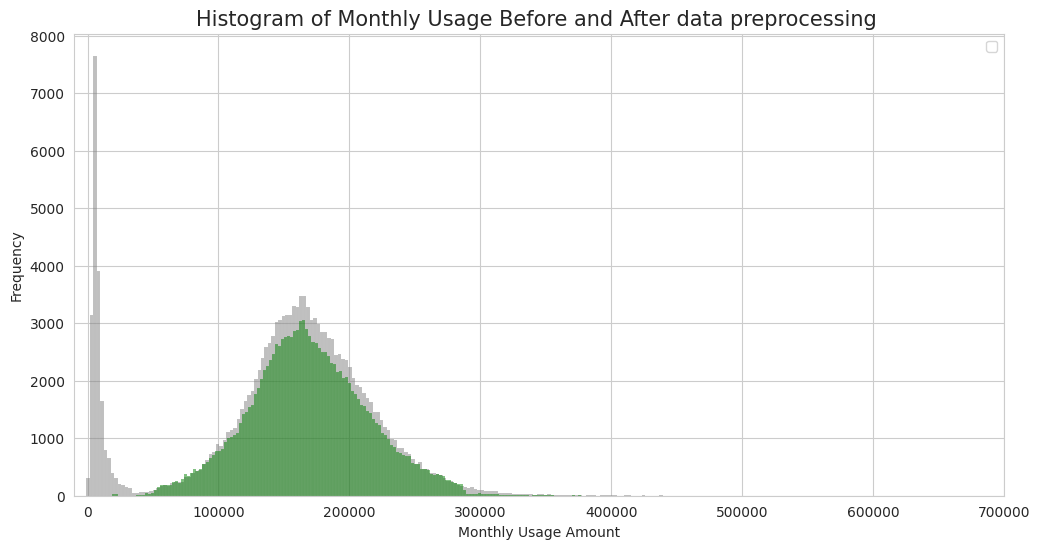

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))  # You can adjust the figure size as needed
# Create the histogram with Seaborn
sns.histplot(filtered_df['Monthly Usage'], color = "grey",alpha=0.5,bins='auto')

# Create the histogram with Seaborn
sns.histplot(store_usage_df['Monthly Usage'], color = "green",alpha=0.5,bins='auto')


# Set the title of the plot
plt.title("Histogram of Monthly Usage Before and After data preprocessing ", fontsize=15)
# Set the x-axis limits to zoom into the dense part of the histogram
plt.xlim(-10000, 700000)
# Add x and y axis labels
plt.xlabel('Monthly Usage Amount')
plt.ylabel('Frequency')
# Show legend
plt.legend()
# Show the plot
plt.show()

In [ ]:
store_usage_df #To save the above file to csv :
store_usage_df.to_csv('/content/drive/MyDrive/Capstone/Fixed_store.csv', index=False)

In [ ]:
import pandas as pd
import plotly.graph_objects as go
df = store_usage_df[store_usage_df['Division']=="Southwest"]
# Ensure 'Service Date' is datetime type
df['Service Date'] = pd.to_datetime(df['Service Date'])
# Extract Year and Month
df['Year'] = df['Service Date'].dt.year
df['Month'] = df['Service Date'].dt.month
# Filter the DataFrame for the desired years
df_filtered = df[(df['Year'] >= 2017) & (df['Year'] <= 2024)]
# Pivot the data to get 'Monthly Usage' for each 'Month' across each 'Year'
df_pivoted = df_filtered.pivot_table(index='Month', columns='Year', values='Monthly Usage', aggfunc='sum')


In [ ]:
df = df_filtered[df_filtered['Division']=="Southwest"]
# Get a list of unique vendors
#vendors = df['Vendor Name'].unique()
#for vendor in vendors:
   # Ensure 'Service Date' is datetime type

df['Service Date'] = pd.to_datetime(df['Service Date'])
# Extract Year and Month
df['Year'] = df['Service Date'].dt.year
df['Month'] = df['Service Date'].dt.month
df_filtered = df[(df['Year'] >= 2018) & (df['Year'] <= 2024)]
# Pivot the data to get 'Monthly Usage' for each 'Month' across each 'Year'
df_pivoted = df_filtered.pivot_table(index='Month', columns='Year', values='Monthly Usage', aggfunc='sum')
# Create a line plot for each year for the current vendor
fig = go.Figure()
# Loop through each year and add a line to the plot
for year in df_pivoted.columns:
    fig.add_trace(go.Scatter(x=df_pivoted.index, y=df_pivoted[year], mode='lines+markers', name=str(year)))
# Update layout
fig.update_layout(title=f'Year-to-Year Monthly Usage Comparison:',
                  xaxis_title='Month',
                  yaxis_title='Monthly Usage',
                  xaxis=dict(tickmode='array', tickvals=list(range(1, 13)), ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
# Show plot
fig.show()

In [ ]:
#To save the above file to csv :
csv_filtered_data = '/content/drive/MyDrive/Capstone/filtered_data.csv'
df_filtered_no_tx.to_csv(csv_filtered_data, index=False)

In [ ]:
#Average Electricity Consumption for each asset type
# Group by 'Asset_Type' and calculate the average 'Monthly Usage' for each asset type
#average_monthly_usage_by_asset_type = merged_df.groupby('Asset Type')['Monthly Usage'].mean()

# Display the result
#print("Average Monthly Usage for each Asset Type:")
#print("")
#for asset_type, avg_usage in average_monthly_usage_by_asset_type.items():
    #print(f"{asset_type}: {avg_usage:.2f} kWh")

In [ ]:
store_usage_df.columns

Index(['Physical ID', 'Asset Type', 'Division', 'City', 'ST', 'ZIP', 'SqFt',
       'Store Opening Date', 'Last Remodel Date', 'Electricity Type',
       'De-regulated Supplier', 'Solar', 'Vendor Name', 'Service Date',
       'Monthly Usage', 'Year', 'Is_outlier'],
      dtype='object')

In [ ]:
average_usage_per_physical_id = store_usage_df.groupby('Physical ID')['Monthly Usage'].mean()

In [ ]:
average_usage_per_physical_id

Physical ID
0151AS    231689.808000
0152AS    193975.386667
0154AS    179309.886667
0155AS    167615.016949
0156AS    136012.220339
              ...      
5022AS    170367.288136
5063AS    247549.633778
5076AS    197852.626667
5082AS    218551.240000
5083AS    127653.372881
Name: Monthly Usage, Length: 2012, dtype: float64

In [ ]:
# Assuming average_usage_per_physical_id contains the mean values obtained from the groupby operation
sorted_average_usage = average_usage_per_physical_id.sort_values(ascending=False)
sorted_average_usage

Physical ID
0225AS    327431.521739
0449AS    307483.297333
0795AS    298156.980444
3637AS    278600.246667
3201AS    278430.488444
              ...      
0764AS     58785.001412
0982AS     57015.087857
0401AS     56209.250000
1985AS     46009.457627
1989AS     20620.440678
Name: Monthly Usage, Length: 2012, dtype: float64

# SEASONAL DECOMPOSITION

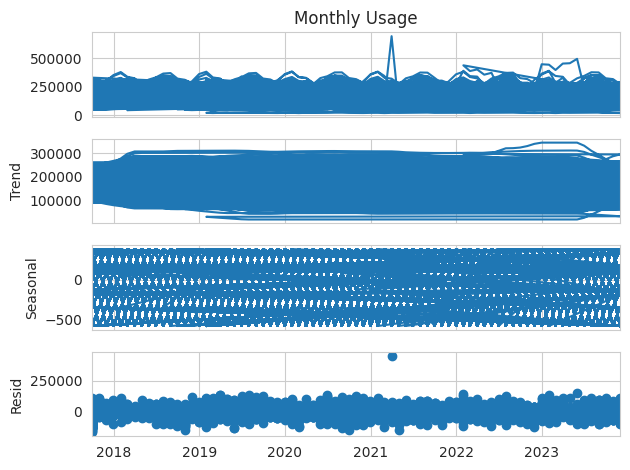

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
df = store_usage_df.copy()
df_sd = df
# First, ensure your DataFrame's date column is of datetime type and set it as the index
df_sd['Service Date'] = pd.to_datetime(df_sd['Service Date'])
df_sd.set_index('Service Date', inplace=True)

# Choose between 'additive' or 'multiplicative' based on your data's characteristics
result = seasonal_decompose(df_sd['Monthly Usage'], model='additive',period=12)

# Plotting the decomposed components of the time series
result.plot()
plt.show()


In [ ]:
store_usage = store_usage_df.copy()

In [ ]:
final_df = pd.merge(store_usage, energy_efficiency_df, left_on='Physical ID', right_on='Physical ID#', how='inner')

In [ ]:
final_df

Physical ID Asset Type    Division_x       City  ST    ZIP   SqFt  \
0           0152AS      Store     Southwest  Henderson  NV  89012  60177   
1           0152AS      Store     Southwest  Henderson  NV  89012  60177   
2           0152AS      Store     Southwest  Henderson  NV  89012  60177   
3           0152AS      Store     Southwest  Henderson  NV  89012  60177   
4           0152AS      Store     Southwest  Henderson  NV  89012  60177   
...            ...        ...           ...        ...  ..    ...    ...   
389522      5083AS      Store  Mid-Atlantic     McLean  VA  22101  35003   
389523      5083AS      Store  Mid-Atlantic     McLean  VA  22101  35003   
389524      5083AS      Store  Mid-Atlantic     McLean  VA  22101  35003   
389525      5083AS      Store  Mid-Atlantic     McLean  VA  22101  35003   
389526      5083AS      Store  Mid-Atlantic     McLean  VA  22101  35003   

       Store Opening Date Last Remodel Date Electricity Type  ...  \
0              2001-02-27        2017-02-22        Regulated  ...   
1              2001-02-27        2017-02-22        Regulated  ...   
2              2001-02-27        2017-02-22        Regulated  ...   
3              2001-02-27        2017-02-22        Regulated  ...   
4              2001-02-27        2017-02-22        Regulated  ...   
...                   ...               ...              ...  ...   
389522         1967-05-03        2018-08-18     De-regulated  ...   
389523         1967-05-03        2018-08-18     De-regulated  ...   
389524         1967-05-03        2018-08-18     De-regulated  ...   
389525         1967-05-03        2018-08-18     De-regulated  ...   
389526         1967-05-03        2018-08-18     De-regulated  ...   

       Service Date Monthly Usage  Year Is_outlier  Physical ID#  \
0        2017-09-30       77204.0  2017      False        0152AS   
1        2017-09-30       77204.0  2017      False        0152AS   
2        2017-09-30       77204.0  2017      False        0152AS   
3        2017-09-30       77204.0  2017      False        0152AS   
4        2017-10-31      214171.0  2017      False        0152AS   
...             ...           ...   ...        ...           ...   
389522   2023-07-31      123114.0  2023      False        5083AS   
389523   2023-08-31      120296.0  2023      False        5083AS   
389524   2023-09-30      120456.0  2023      False        5083AS   
389525   2023-10-31      119579.0  2023      False        5083AS   
389526   2023-11-30      105737.0  2023      False        5083AS   

          Division_y         Project Sub-Type Electric kWh Savings  \
0          Southwest  LED Interior & Exterior             420134.0   
1          Southwest   Case Door Installation              66367.0   
2          Southwest        Frozen Food Cases             150000.0   
3          Southwest   Case Door Installation             208500.0   
4          Southwest  LED Interior & Exterior             420134.0   
...              ...                      ...                  ...   
389522  Mid-Atlantic  LED Interior & Exterior             183685.0   
389523  Mid-Atlantic  LED Interior & Exterior             183685.0   
389524  Mid-Atlantic  LED Interior & Exterior             183685.0   
389525  Mid-Atlantic  LED Interior & Exterior             183685.0   
389526  Mid-Atlantic  LED Interior & Exterior             183685.0   

       Electric Savings $ Savings Completion Date  
0                35291.00              2021-05-21  
1                 5573.00              2023-07-10  
2                     NaN              2023-08-04  
3                18207.75              2023-01-18  
4                35291.00              2021-05-21  
...                   ...                     ...  
389522           12858.00              2020-08-10  
389523           12858.00              2020-08-10  
389524           12858.00              2020-08-10  
389525           12858.00              2020-08-10  
389526           12858.00          

# **FORECAST MODEL**

DATA SPLITTING

In [ ]:
# Assuming 'ds' is the column with your dates and 'y' is the column with the values you want to predict
store_data = store_usage_df.copy()
store_data = store_data.sort_values(by=['Physical ID', 'Service Date'])

# Split the data into training and validation sets
validation = store_data.iloc[-12:]

In [ ]:
#train = train.reset_index(drop=True)


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Create figure
fig = go.Figure()

# Add traces for train actuals, validation actuals, and predicted values
fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Train Actuals'))
fig.add_trace(go.Scatter(x=validation['ds'], y=validation['y'], mode='lines', name='Validation Actuals'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Predicted', line=dict(dash='dash')))

# Highlight the validation period - Plotly doesn't support axvspan equivalent directly, so we use a Rectangle shape
fig.add_vrect(x0=validation['ds'].iloc[0], x1=validation['ds'].iloc[-1],
              fillcolor="lightgrey", opacity=0.2, line_width=0,
              annotation_text="Validation Period", annotation_position="top left")

# Set plot titles and labels
fig.update_layout(title='Monthly Usage Forecast vs Actuals',
                  xaxis_title='Date',
                  yaxis_title='Monthly Usage',
                  legend_title='Legend')

# Show plot
fig.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ensure the validation set and forecast are aligned by date
# You can merge the validation set with the forecast to align them
validation_forecast = pd.merge(validation, forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate MSE
mse = mean_squared_error(validation_forecast['y'], validation_forecast['yhat'])

# Calculate MAPE - Mean Absolute Percentage Error
mape = np.mean(np.abs((validation_forecast['y'] - validation_forecast['yhat']) / validation_forecast['y'])) * 100

# Calculate RMSE - Root Mean Squared Error
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAPE: {mape}%')
print(f'RMSE: {rmse}')


DOWNLOADING FORECASTED DATASET

In [ ]:
import pandas as pd

# Filter relevant columns
results = forecast[['ds', 'yhat']]  # 'ds' for date and 'yhat' for forecasted usage

# Since 'Physical ID' is fixed for this forecast, assign it directly
results['Physical ID'] = future["Physical ID"]

# Rename columns to match your requirement
results.rename(columns={'ds': 'Service Date', 'yhat': 'Forecasted Usage'}, inplace=True)

# Save the results to a CSV file
results.to_csv('forecasted_usage.csv', index=False)


In [ ]:
from prophet import Prophet
import pandas as pd

data = final_df.copy()
df = final_df.copy()
# Filter the dataset for "Regulated" electricity types and a specific division
# Example: Let's choose the 'Southwest' division for this example
store_pred = data[(data['Physical ID'] == '1446AS')]

# Ensure "SERVICE BEGIN DATE" is in datetime format and sort by date
store_pred['Service_Month'] = pd.to_datetime(store_pred['Service Date'])
store_pred['Last_Remodel_Date'] = pd.to_datetime(store_pred['Last Remodel Date'])
store_pred['Savings_Completion_Date'] = pd.to_datetime(store_pred['Savings Completion Date'])
store_pred = store_pred.sort_values(by='Service_Month')

# Remove December 2023 from the Service_Month
store_pred = store_pred[~((store_pred['Service_Month'].dt.year == 2023) & (store_pred['Service_Month'].dt.month == 12))]

# Aggregate the usage for the same BILL MONTH
store_pred = store_pred.groupby('Service_Month')['Monthly Usage'].sum().reset_index()

# Prepare the DataFrame for Prophet
# Prophet requires the dataframe to have two columns: "ds" (datestamp) and "y" (value we wish to forecast)
prophet_2 = store_pred.rename(columns={'Service_Month': 'ds', 'Monthly Usage': 'y'})
prophet_3 = store_pred.rename(columns={'Service_Month': 'ds', 'Monthly Usage': 'y'})

# Initialize and fit the model
model_2 = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_3 = Prophet(growth="linear",seasonality_prior_scale=100,seasonality_mode="multiplicative").add_seasonality(name='monthly', period=36, fourier_order=10)

model_2.fit(prophet_2)
model_3.fit(prophet_3)

# Create a dataframe for future dates (let's forecast for the next 36 months)
future_2 = model_2.make_future_dataframe(periods=36, freq='M')
future_3 = model_3.make_future_dataframe(periods=36, freq='M')

# Predict future values
forecast_2 = model_2.predict(future_2)
forecast_3 = model_3.predict(future_3)

# Plot the actual data
actual_2 = go.Scatter(x=store_pred['Service_Month'], y=store_pred['Monthly Usage'], mode='lines', name='Actual', line=dict(color='purple'))


# Find the first occurrence of Last Remodel Date and energy_savings date
first_remodel_date = df['Last Remodel Date'].iloc[0]
energy_saving_date = df['Savings Completion Date'].iloc[0]

# Add markers for the first occurrence of Last Remodel Date and Savings_Completion_Date
markers_1 = go.Scatter(x=[first_remodel_date], y=[df.loc[df['Last Remodel Date'] == first_remodel_date, 'Monthly Usage'].iloc[0]],
                     mode='markers', name='Last Remodel Date', marker=dict(color='magenta', size=12))
markers_2 = go.Scatter(x=[energy_saving_date], y=[df.loc[df['Savings Completion Date'] == energy_saving_date, 'Monthly Usage'].iloc[0]],
                     mode='markers', name='Savings Completion Date', marker=dict(color='black', size=12))
# Add dashed lines for the first occurrence of Last Remodel Date and Savings_Completion_Date
line_1 = go.Scatter(x=[first_remodel_date, first_remodel_date],
                    y=[0, data['Monthly Usage'].max()], # Adjust y-values to span the graph vertically
                    mode='lines',
                    name='Last Remodel Date',
                    line=dict(color='magenta', width=2, dash='dash'))

line_2 = go.Scatter(x=[energy_saving_date, energy_saving_date],
                    y=[0, 300000], # Adjust y-values to span the graph vertically
                    mode='lines',
                    name='Savings Completion Date',
                    line=dict(color='black', width=2, dash='dash'))

# Plot the forecast
forecast_plotly_2 = go.Scatter(x=forecast_2['ds'], y=forecast_2['yhat'], mode='lines', name='Forecast 1', line=dict(color='aqua'))
# Plot the forecast
forecast_plotly_3 = go.Scatter(x=forecast_3['ds'], y=forecast_3['yhat'], mode='lines', name='Forecast 2', line=dict(color='orange'))


# Create hovertext for forecast
hover_text_forecast_2 = [f"Date: {date.strftime('%Y-%m')}, Forecast 1: {forecast_val}"
                       for date, forecast_val in zip(forecast_2['ds'], forecast_2['yhat'])]

# Create hovertext for actual data
hover_text_actual_2 = [f"Date: {date.strftime('%Y-%m')}, Actual: {actual_val}"
                     for date, actual_val in zip(store_pred['Service_Month'], store_pred['Monthly Usage'])]

# Create the figure
fig_2 = go.Figure(data=[actual_2,forecast_plotly_3,line_2])

# Update layout with title and axis labels
fig_2.update_layout(title='Electricity Usage Forecast for X Division',
                  xaxis_title='Date',
                  yaxis_title='Monthly Usage')

# Show the figure
fig_2.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/gwmr1w6z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/fip7cmzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45946', 'data', 'file=/tmp/tmpng3slj3_/gwmr1w6z.json', 'init=/tmp/tmpng3slj3_/fip7cmzp.json', 'output', 'file=/tmp/tmpng3slj3_/prophet_model_5vozlgd/prophet_model-20240425023938.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:39:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:39:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

In [ ]:
import plotly.graph_objects as go
from prophet import Prophet
import pandas as pd

data = final_df.copy()
df = final_df.copy()
# Filter the dataset for "Regulated" electricity types and a specific division
# Example: Let's choose the 'Southwest' division for this example
store_pred = data[(data['Physical ID'] == '1446AS')]

# Ensure "SERVICE BEGIN DATE" is in datetime format and sort by date
store_pred['Service_Month'] = pd.to_datetime(store_pred['Service Date'])
store_pred['Last_Remodel_Date'] = pd.to_datetime(store_pred['Last Remodel Date'])
store_pred['Savings_Completion_Date'] = pd.to_datetime(store_pred['Savings Completion Date'])
store_pred = store_pred.sort_values(by='Service_Month')

# Remove December 2023 from the Service_Month
store_pred = store_pred[~((store_pred['Service_Month'].dt.year == 2023) & (store_pred['Service_Month'].dt.month == 12))]

# Aggregate the usage for the same BILL MONTH
store_pred = store_pred.groupby('Service_Month')['Monthly Usage'].sum().reset_index()

# Prepare the DataFrame for Prophet
# Prophet requires the dataframe to have two columns: "ds" (datestamp) and "y" (value we wish to forecast)
prophet_2 = store_pred.rename(columns={'Service_Month': 'ds', 'Monthly Usage': 'y'})
prophet_3 = store_pred.rename(columns={'Service_Month': 'ds', 'Monthly Usage': 'y'})

# Initialize and fit the model
model_2 = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_3 = Prophet(growth="linear",seasonality_prior_scale=100,seasonality_mode="multiplicative").add_seasonality(name='monthly', period=36, fourier_order=10)

model_2.fit(prophet_2)
model_3.fit(prophet_3)

# Create a dataframe for future dates (let's forecast for the next 36 months)
future_2 = model_2.make_future_dataframe(periods=36, freq='M')
future_3 = model_3.make_future_dataframe(periods=36, freq='M')

# Predict future values
forecast_2 = model_2.predict(future_2)
forecast_3 = model_3.predict(future_3)

# Plot the actual data
actual_plot = go.Scatter(
    x=store_pred['Service_Month'],
    y=store_pred['Monthly Usage'],
    mode='lines',
    name='Actual',
    line=dict(color='purple')
)

# Plot the forecast starting from November 2023
forecast_plotly_2 = go.Scatter(
    x=forecast_2[forecast_2['ds'] >= '2023-11-01']['ds'],
    y=forecast_2[forecast_2['ds'] >= '2023-11-01']['yhat'],
    mode='lines',
    name='Forecast 1',
    line=dict(color='aqua')
)

forecast_plotly_3 = go.Scatter(
    x=forecast_3[forecast_3['ds'] >= '2023-11-01']['ds'],
    y=forecast_3[forecast_3['ds'] >= '2023-11-01']['yhat'],
    mode='lines',
    name='Forecast 2',
    line=dict(color='orange')
)

# Add markers for the first occurrence of Last Remodel Date and Savings_Completion_Date
markers_1 = go.Scatter(
    x=[first_remodel_date],
    y=[df.loc[df['Last Remodel Date'] == first_remodel_date, 'Monthly Usage'].iloc[0]],
    mode='markers',
    name='Last Remodel Date',
    marker=dict(color='magenta', size=12)
)

markers_2 = go.Scatter(
    x=[energy_saving_date],
    y=[df.loc[df['Savings Completion Date'] == energy_saving_date, 'Monthly Usage'].iloc[0]],
    mode='markers',
    name='Savings Completion Date',
    marker=dict(color='black', size=12)
)

# Add dashed lines for the first occurrence of Last Remodel Date and Savings_Completion_Date
line_1 = go.Scatter(
    x=[first_remodel_date, first_remodel_date],
    y=[0, df['Monthly Usage'].max()],  # Adjust y-values to span the graph vertically
    mode='lines',
    name='Last Remodel Date',
    line=dict(color='magenta', width=2, dash='dash')
)

line_2 = go.Scatter(
    x=[energy_saving_date, energy_saving_date],
    y=[0, 300000],  # Adjust y-values to span the graph vertically
    mode='lines',
    name='Savings Completion Date',
    line=dict(color='black', width=2, dash='dash')
)

# Create the figure
fig_2 = go.Figure(data=[actual_plot, forecast_plotly_2, forecast_plotly_3])

# Update layout with title and axis labels
fig_2.update_layout(
    title='Electricity Usage Forecast for X Division',
    xaxis_title='Date',
    yaxis_title='Monthly Usage'
)

# Show the figure
fig_2.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/zx6gj071.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/7sdc_7t1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9695', 'data', 'file=/tmp/tmpng3slj3_/zx6gj071.json', 'init=/tmp/tmpng3slj3_/7sdc_7t1.json', 'output', 'file=/tmp/tmpng3slj3_/prophet_modelc6owoola/prophet_model-20240425023944.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:39:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:39:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

In [ ]:
import plotly.graph_objects as go
from prophet import Prophet
import pandas as pd

# Prepare and filter data, assume 'final_df' is pre-loaded with the necessary data
data = final_df.copy()
store_pred = data[(data['Physical ID'] == '2049AS')]
store_pred['Service_Month'] = pd.to_datetime(store_pred['Service Date'])
store_pred = store_pred.sort_values(by='Service_Month')

# Prepare the DataFrame for Prophet
prophet_data = store_pred.rename(columns={'Service_Month': 'ds', 'Monthly Usage': 'y'})

# Initialize and fit the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_data)

# Create a dataframe for future dates (forecasting for the next 36 months)
future_dates = model.make_future_dataframe(periods=36, freq='M')

# Predict future values
forecast = model.predict(future_dates)

# Plot the actual data
actual_plot = go.Scatter(
    x=store_pred['Service_Month'],
    y=store_pred['Monthly Usage'],
    mode='lines',
    name='Actual Usage',
    line=dict(color='purple')
)

# Filter forecast data to start from November 2023 for plotting
forecast_plot = go.Scatter(
    x=forecast[forecast['ds'] >= '2023-11-01']['ds'],
    y=forecast[forecast['ds'] >= '2023-11-01']['yhat'],
    mode='lines',
    name='Forecasted Usage',
    line=dict(color='orange')
)

# Create the figure
fig = go.Figure()

# Add traces
fig.add_trace(actual_plot)
fig.add_trace(forecast_plot)

# Update layout with title and axis labels, including interactive elements
fig.update_layout(
    title='Electricity Usage Forecast vs Actual',
    xaxis_title='Date',
    yaxis_title='Electricity Usage (kWh)',
    legend_title="Legend",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

# Show the figure
fig.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/jpvxxbup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/hyi_xeap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55227', 'data', 'file=/tmp/tmpng3slj3_/jpvxxbup.json', 'init=/tmp/tmpng3slj3_/hyi_xeap.json', 'output', 'file=/tmp/tmpng3slj3_/prophet_modelvbwz_vd3/prophet_model-20240425024011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:40:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:40:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Convert 'Service Date' to datetime and sort
data['Service_Month'] = pd.to_datetime(data['Service Date'])
data = data.sort_values(by='Service_Month')

# Aggregate usage across all physical IDs for each Service Month
aggregated_data = data.groupby('Service_Month')['Monthly Usage'].sum().reset_index()

# Detect and remove outliers - this is a simplistic method; consider a more robust approach for your actual use case
Q1 = aggregated_data['Monthly Usage'].quantile(0.25)
Q3 = aggregated_data['Monthly Usage'].quantile(0.75)
IQR = Q3 - Q1
filter = (aggregated_data['Monthly Usage'] >= Q1 - 1.5 * IQR) & (aggregated_data['Monthly Usage'] <= Q3 + 1.5 * IQR)
cleaned_data = aggregated_data.loc[filter]


In [ ]:
# Continue with Prophet forecasting using 'cleaned_data'
from prophet import Prophet
import plotly.graph_objects as go

# Rename the columns for Prophet compatibility
prophet_data = cleaned_data.rename(columns={'Service_Month': 'ds', 'Monthly Usage': 'y'})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Create a dataframe for future dates (forecasting for the next 36 months)
future_dates = model.make_future_dataframe(periods=36, freq='M')

# Predict future values
forecast = model.predict(future_dates)

# Now, plotting the actual versus forecasted data

# Plot the actual data
actual_plot = go.Scatter(
    x=prophet_data['ds'],
    y=prophet_data['y'],
    mode='lines+markers',
    name='Actual Usage',
    line=dict(color='purple')
)

# Filter forecast data to start plotting the forecast from November 2023
forecast_filtered = forecast[forecast['ds'] >= '2023-11-01']

# Plot forecast data
forecast_plot = go.Scatter(
    x=forecast_filtered['ds'],
    y=forecast_filtered['yhat'],
    mode='lines',
    name='Forecasted Usage',
    line=dict(color='orange')
)

# Create the figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(actual_plot)
fig.add_trace(forecast_plot)

# Update layout with title and axis labels, including interactive elements
fig.update_layout(
    title='Electricity Usage Forecast vs Actual',
    xaxis_title='Date',
    yaxis_title='Electricity Usage (kWh)',
    legend_title="Legend",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

# Show the figure
fig.show()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/bgg6faqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/gm99cqaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72331', 'data', 'file=/tmp/tmpng3slj3_/bgg6faqk.json', 'init=/tmp/tmpng3slj3_/gm99cqaq.json', 'output', 'file=/tmp/tmpng3slj3_/prophet_model5myqeui1/prophet_model-20240425024024.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:40:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:40:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
from prophet import Prophet
import pandas as pd

data = final_df.copy()
df = final_df.copy()
# Filter the dataset for "Regulated" electricity types and a specific division
# Example: Let's choose the 'Southwest' division for this example
store_pred = data[(data['Physical ID'] == '1446AS')]

# Ensure "SERVICE BEGIN DATE" is in datetime format and sort by date
store_pred['Service_Month'] = pd.to_datetime(store_pred['Service Date'])
store_pred['Last_Remodel_Date'] = pd.to_datetime(store_pred['Last Remodel Date'])
store_pred['Savings_Completion_Date'] = pd.to_datetime(store_pred['Savings Completion Date'])
store_pred = store_pred.sort_values(by='Service_Month')

# Remove December 2023 from the Service_Month
store_pred = store_pred[~((store_pred['Service_Month'].dt.year == 2023) & (store_pred['Service_Month'].dt.month == 12))]

# Aggregate the usage for the same BILL MONTH
store_pred = store_pred.groupby('Service_Month')['Monthly Usage'].sum().reset_index()

# Prepare the DataFrame for Prophet
# Prophet requires the dataframe to have two columns: "ds" (datestamp) and "y" (value we wish to forecast)
prophet_2 = store_pred.rename(columns={'Service_Month': 'ds', 'Monthly Usage': 'y'})
prophet_3 = store_pred.rename(columns={'Service_Month': 'ds', 'Monthly Usage': 'y'})

# Initialize and fit the model
model_2 = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_3 = Prophet(growth="linear",seasonality_prior_scale=100,seasonality_mode="multiplicative").add_seasonality(name='monthly', period=36, fourier_order=10)

model_2.fit(prophet_2)
model_3.fit(prophet_3)

# Create a dataframe for future dates (let's forecast for the next 36 months)
future_2 = model_2.make_future_dataframe(periods=36, freq='M')
future_3 = model_3.make_future_dataframe(periods=36, freq='M')

# Predict future values
forecast_2 = model_2.predict(future_2)
forecast_3 = model_3.predict(future_3)

# Plot the actual data
actual_2 = go.Scatter(x=store_pred['Service_Month'], y=store_pred['Monthly Usage'], mode='lines', name='Actual', line=dict(color='purple'))


# Find the first occurrence of Last Remodel Date and energy_savings date
first_remodel_date = df['Last Remodel Date'].iloc[0]
energy_saving_date = df['Savings Completion Date'].iloc[0]

# Add markers for the first occurrence of Last Remodel Date and Savings_Completion_Date
markers_1 = go.Scatter(x=[first_remodel_date], y=[df.loc[df['Last Remodel Date'] == first_remodel_date, 'Monthly Usage'].iloc[0]],
                     mode='markers', name='Last Remodel Date', marker=dict(color='magenta', size=12))
markers_2 = go.Scatter(x=[energy_saving_date], y=[df.loc[df['Savings Completion Date'] == energy_saving_date, 'Monthly Usage'].iloc[0]],
                     mode='markers', name='Savings Completion Date', marker=dict(color='black', size=12))
# Add dashed lines for the first occurrence of Last Remodel Date and Savings_Completion_Date
line_1 = go.Scatter(x=[first_remodel_date, first_remodel_date],
                    y=[0, data['Monthly Usage'].max()], # Adjust y-values to span the graph vertically
                    mode='lines',
                    name='Last Remodel Date',
                    line=dict(color='magenta', width=2, dash='dash'))

line_2 = go.Scatter(x=[energy_saving_date, energy_saving_date],
                    y=[0, 300000], # Adjust y-values to span the graph vertically
                    mode='lines',
                    name='Savings Completion Date',
                    line=dict(color='black', width=2, dash='dash'))

# Plot the forecast
forecast_plotly_2 = go.Scatter(x=forecast_2['ds'], y=forecast_2['yhat'], mode='lines', name='Forecast 1', line=dict(color='aqua'))
# Plot the forecast
forecast_plotly_3 = go.Scatter(x=forecast_3['ds'], y=forecast_3['yhat'], mode='lines', name='Forecast 2', line=dict(color='orange'))


# Create hovertext for forecast
hover_text_forecast_2 = [f"Date: {date.strftime('%Y-%m')}, Forecast 1: {forecast_val}"
                       for date, forecast_val in zip(forecast_2['ds'], forecast_2['yhat'])]

# Create hovertext for actual data
hover_text_actual_2 = [f"Date: {date.strftime('%Y-%m')}, Actual: {actual_val}"
                     for date, actual_val in zip(store_pred['Service_Month'], store_pred['Monthly Usage'])]

# Create the figure
fig_2 = go.Figure(data=[actual_2,forecast_plotly_2,forecast_plotly_3,line_2])

# Update layout with title and axis labels
fig_2.update_layout(title='Electricity Usage Forecast for Store 1446AS',
                  xaxis_title='Date',
                  yaxis_title='Monthly Usage')

# Show the figure
fig_2.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/43ysy9pi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/fcs7oej8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13939', 'data', 'file=/tmp/tmpng3slj3_/43ysy9pi.json', 'init=/tmp/tmpng3slj3_/fcs7oej8.json', 'output', 'file=/tmp/tmpng3slj3_/prophet_modelx313gyif/prophet_model-20240425032638.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

In [ ]:
from prophet import Prophet
import pandas as pd

data = final_df.copy()
df = final_df.copy()
# Filter the dataset for "Regulated" electricity types and a specific division
# Example: Let's choose the 'Southwest' division for this example
store_pred = data

# Ensure "SERVICE BEGIN DATE" is in datetime format and sort by date
store_pred['Service_Month'] = pd.to_datetime(store_pred['Service Date'])
store_pred['Last_Remodel_Date'] = pd.to_datetime(store_pred['Last Remodel Date'])
store_pred['Savings_Completion_Date'] = pd.to_datetime(store_pred['Savings Completion Date'])
store_pred = store_pred.sort_values(by='Service_Month')

# Remove December 2023 from the Service_Month
store_pred = store_pred[~((store_pred['Service_Month'].dt.year == 2023) & (store_pred['Service_Month'].dt.month == 12))]

# Aggregate the usage for the same BILL MONTH
store_pred = store_pred.groupby('Service_Month')['Monthly Usage'].sum().reset_index()

# Prepare the DataFrame for Prophet
# Prophet requires the dataframe to have two columns: "ds" (datestamp) and "y" (value we wish to forecast)
prophet_2 = store_pred.rename(columns={'Service_Month': 'ds', 'Monthly Usage': 'y'})
prophet_3 = store_pred.rename(columns={'Service_Month': 'ds', 'Monthly Usage': 'y'})

# Initialize and fit the model
model_2 = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_3 = Prophet(growth="linear",seasonality_prior_scale=100,seasonality_mode="multiplicative").add_seasonality(name='monthly', period=36, fourier_order=10)

model_2.fit(prophet_2)
model_3.fit(prophet_3)

# Create a dataframe for future dates (let's forecast for the next 36 months)
future_2 = model_2.make_future_dataframe(periods=36, freq='M')
future_3 = model_3.make_future_dataframe(periods=36, freq='M')

# Predict future values
forecast_2 = model_2.predict(future_2)
forecast_3 = model_3.predict(future_3)

# Plot the actual data
actual_2 = go.Scatter(x=store_pred['Service_Month'], y=store_pred['Monthly Usage'], mode='lines', name='Actual', line=dict(color='purple'))


# Find the first occurrence of Last Remodel Date and energy_savings date
first_remodel_date = df['Last Remodel Date'].iloc[0]
energy_saving_date = df['Savings Completion Date'].iloc[0]

# Add markers for the first occurrence of Last Remodel Date and Savings_Completion_Date
markers_1 = go.Scatter(x=[first_remodel_date], y=[df.loc[df['Last Remodel Date'] == first_remodel_date, 'Monthly Usage'].iloc[0]],
                     mode='markers', name='Last Remodel Date', marker=dict(color='magenta', size=12))
markers_2 = go.Scatter(x=[energy_saving_date], y=[df.loc[df['Savings Completion Date'] == energy_saving_date, 'Monthly Usage'].iloc[0]],
                     mode='markers', name='Savings Completion Date', marker=dict(color='black', size=12))
# Add dashed lines for the first occurrence of Last Remodel Date and Savings_Completion_Date
line_1 = go.Scatter(x=[first_remodel_date, first_remodel_date],
                    y=[0, data['Monthly Usage'].max()], # Adjust y-values to span the graph vertically
                    mode='lines',
                    name='Last Remodel Date',
                    line=dict(color='magenta', width=2, dash='dash'))

line_2 = go.Scatter(x=[energy_saving_date, energy_saving_date],
                    y=[0, 300000], # Adjust y-values to span the graph vertically
                    mode='lines',
                    name='Savings Completion Date',
                    line=dict(color='black', width=2, dash='dash'))

# Plot the forecast
forecast_plotly_2 = go.Scatter(x=forecast_2['ds'], y=forecast_2['yhat'], mode='lines', name='Forecast 1', line=dict(color='aqua'))
# Plot the forecast
forecast_plotly_3 = go.Scatter(x=forecast_3['ds'], y=forecast_3['yhat'], mode='lines', name='Forecast 2', line=dict(color='orange'))


# Create hovertext for forecast
hover_text_forecast_2 = [f"Date: {date.strftime('%Y-%m')}, Forecast 1: {forecast_val}"
                       for date, forecast_val in zip(forecast_2['ds'], forecast_2['yhat'])]

# Create hovertext for actual data
hover_text_actual_2 = [f"Date: {date.strftime('%Y-%m')}, Actual: {actual_val}"
                     for date, actual_val in zip(store_pred['Service_Month'], store_pred['Monthly Usage'])]

# Create the figure
fig_2 = go.Figure(data=[actual_2,forecast_plotly_2,forecast_plotly_3,line_2])

# Update layout with title and axis labels
fig_2.update_layout(title='Electricity Usage Forecast for all stores',
                  xaxis_title='Date',
                  yaxis_title='Monthly Usage')

# Show the figure
fig_2.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/60cicya3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpng3slj3_/pesm_cqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97704', 'data', 'file=/tmp/tmpng3slj3_/60cicya3.json', 'init=/tmp/tmpng3slj3_/pesm_cqy.json', 'output', 'file=/tmp/tmpng3slj3_/prophet_modeld1g76zvf/prophet_model-20240425032714.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:27:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:27:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

In [ ]:
from sklearn.metrics import mean_squared_error

# Ensure that 'ds' in prophet_df_2 is in datetime format, just like in forecast_2 for accurate merging
prophet_df_2['ds'] = pd.to_datetime(prophet_df_2['ds'])

# Filter forecast_2 to include only the dates that exist in prophet_df_2 (historical data period)
forecast_2_filtered = forecast_2[forecast_2['ds'].isin(prophet_df_2['ds'])]

# Merge the actual historical data with the filtered forecasted data on dates
evaluation_df = pd.merge(prophet_df_2, forecast_2_filtered[['ds', 'yhat']], on='ds', how='left')

# Calculate the MSE between the actual 'y' values and the forecasted 'yhat' values
mse = mean_squared_error(evaluation_df['y'], evaluation_df['yhat'])

print(f"Mean Squared Error (MSE) of the Forecast: {mse}")
